In [1]:
from ROOT import TFile
from ROOT import TCanvas, TPad, TLegend, TLatex

Welcome to JupyROOT 6.26/00


In [2]:
eta_bins = [0, 0.9, 1.2, 2.1, 2.4]
pt_bins = [10., 15., 20., 25., 30., 40., 50., 60., 120., 200., 300, 500.]

In [3]:
IDs = [
    "POGMedium",
    "POGMedium-dZ01",
    "POGMedium-dZ01-SIP4",
    "POGMedium-dZ01-SIP4-miniIso01"
]
lumi_dict = {
    "2016preVFP": 19.8,
    "2016postVFP": 19.8,
    "2017": 41.5,
    "2018": 59.7
}

In [4]:
def get_histo(era="2016preVFP", isData=True):
    dict_histo = {}
    for name in IDs:
        fkey = f"{era}/Muon/Effi_{name}.root"
        hkey = "muonEffi_data_eta_pt" if isData else "muonEffi_mc_eta_pt"
        f = TFile.Open(fkey); h = f.Get(hkey)
        h.SetDirectory(0)
        
        dict_histo[name] = h
    
    return dict_histo

In [5]:
def generate_configs(era="2016preVFP", iptbin=0, ietabin=0):
    # if iptbin/ietabin == 0, it means config is inclusive
    # with respect to the bin
    if iptbin == 0 and ietabin == 0:
        print("at most one bin can be inclusive")
        raise(ValueError)
    if iptbin * ietabin != 0:
        print("at least one variable should be inclusive(==0)")
        raise(ValueError)
    if iptbin < 0 or iptbin > 11:
        print("out of range for pt")
        raise(ValueError)
    if ietabin < 0 or ietabin > 4:
        print("out of range for eta")
        raise(ValueError)
    
    configs = dict()
    configs['iptbin'] = iptbin
    configs['ietabin'] = ietabin
    if iptbin == 0:
        configs["x_range"] = [10, 120]
        configs["eff_range"] = [0.4, 1.2]
        configs["ratio_range"] = [0.6, 1.4]
        configs["extra_info"] = f"{eta_bins[ietabin-1]} < |#eta| < {eta_bins[ietabin]}"
    if ietabin == 0:
        configs["x_range"] = [0., 2.4]
        configs["eff_range"] = [0.4, 1.2]
        configs["ratio_range"] = [0.6, 1.4]
        configs["extra_info"] = f"{int(pt_bins[iptbin-1])} < " + "p_{T}" f" < {int(pt_bins[iptbin])} [GeV]"
    configs['info'] = "L^{int} = " + f"{lumi_dict[era]} /fb"
    
    return configs

In [6]:
class Canvas():
    def __init__(self, configs=None):
        self.cvs = TCanvas("c", "", 720, 900)
        self.pad_up = TPad("up", "", 0, 0.25, 1, 1)
        #self.pad_up.SetGrid(True)
        self.pad_up.SetBottomMargin(0.02)
        self.pad_down = TPad("down", "", 0, 0, 1, 0.25)
        self.pad_down.SetGrid(True)
        self.pad_down.SetTopMargin(0.08)
        self.pad_down.SetBottomMargin(0.3)
        
        self.legend = TLegend(0.55, 0.1, 0.9, 0.45)
        self.legend.SetFillStyle(0)
        self.legend.SetBorderSize(0)
        #self.legend.SetNColumns(2)
        
        self.info = TLatex()
        self.info.SetTextSize(0.03)
        self.info.SetTextFont(42)
        self.logo = TLatex()
        self.logo.SetTextSize(0.04)
        self.logo.SetTextFont(61)
        self.extra_info = TLatex()
        self.extra_info.SetTextSize(0.035)
        self.extra_info.SetTextFont(52)
        self.extra_logo = TLatex()
        self.extra_logo.SetTextSize(0.035)
        self.extra_logo.SetTextFont(52)
        
        self.configs = configs
    
    def get_hists(self, effis):
        self.originals = effis
        self.__project_histograms()
        self.__make_ratios()
        self.__decorate()
        
    def __project_histograms(self):
        self.effis = dict()
        if self.configs['iptbin'] == 0:
            # pt-inclusive
            ietabin = self.configs['ietabin']
            for name, hist in self.originals.items():
                self.effis[name] = hist.ProjectionY(f"p_{name}", ietabin, ietabin)
        if self.configs['ietabin'] == 0:
            # eta-inclusive
            iptbin = self.configs['iptbin']
            for name, hist in self.originals.items():
                self.effis[name] = hist.ProjectionX(f"p_{name}", iptbin, iptbin)
            
    def __make_ratios(self):
        self.ratios = dict()
        default = self.effis[list(self.effis.keys())[0]]
        for name, hist in self.effis.items():
            self.ratios[name] = hist.Clone(f"ratio_{name}")
            self.ratios[name].Divide(default)
    
    def __decorate(self):
        if "eff_range" in self.configs.keys():
            down = self.configs['eff_range'][0]
            up = self.configs['eff_range'][1]
        else:
            down = 0.4
            up = 1.3
        
        colors = [1, 2, 8, 4, 6]
        for i, (name, hist) in enumerate(self.effis.items()):
            hist.SetStats(0)
            hist.SetTitle("")
            hist.GetXaxis().SetTitleSize(0)
            hist.GetXaxis().SetLabelSize(0)
            if "x_range" in self.configs.keys():
                left = self.configs['x_range'][0]
                right = self.configs['x_range'][1]
                hist.GetXaxis().SetRangeUser(left, right)
            #hist.GetXaxis().SetRangeUser(10., 200.)
            hist.GetYaxis().SetTitle("efficiency")
            hist.GetYaxis().SetTitleOffset(1.25)
            if "eff_range" in self.configs.keys():
                down = self.configs["eff_range"][0]
                up = self.configs["eff_range"][1]
                hist.GetYaxis().SetRangeUser(down, up)
            hist.SetLineColor(colors[i])
            hist.SetMarkerColor(colors[i])
            hist.SetMarkerStyle(21)
            hist.SetMarkerSize(1)
            
        for i, (name, hist) in enumerate(self.ratios.items()):
            hist.SetStats(0)
            hist.SetTitle("")
            hist.GetXaxis().SetTitle("p_{T} [GeV]")
            hist.GetXaxis().SetTitleSize(0.1)
            hist.GetXaxis().SetTitleOffset(0.9)
            hist.GetXaxis().SetLabelSize(0.08)
            if "x_range" in self.configs.keys():
                left = self.configs['x_range'][0]
                right = self.configs['x_range'][1]
                hist.GetXaxis().SetRangeUser(left, right)
            hist.GetYaxis().SetTitle("x / POGMedium")
            hist.GetYaxis().CenterTitle()
            hist.GetYaxis().SetTitleSize(0.1)
            hist.GetYaxis().SetTitleOffset(0.4)
            hist.GetYaxis().SetLabelSize(0.08)
            if "ratio_range" in self.configs.keys():
                down = self.configs["ratio_range"][0]
                up = self.configs["ratio_range"][1]
                hist.GetYaxis().SetRangeUser(down, up)
            hist.SetLineColor(colors[i])
            hist.SetMarkerColor(colors[i])
            hist.SetMarkerStyle(20)
            hist.SetMarkerSize(0.6)
            
    def combine(self):
        self.pad_up.cd()
        for name in self.effis.keys():
            self.effis[name].Draw("p&same")
            self.legend.AddEntry(self.effis[name], name, 'lep')
        self.legend.Draw("same")
        if "info" in self.configs.keys():
            self.info.DrawLatexNDC(0.74, 0.91, self.configs["info"])
        self.logo.DrawLatexNDC(0.15, 0.83, "CMS")
        self.extra_logo.DrawLatexNDC(0.15, 0.78, "Work in progress")
        
        if "extra_info" in self.configs.keys():
            self.extra_info.DrawLatexNDC(0.58, 0.8, self.configs["extra_info"])
        
        self.pad_down.cd()
        for name in self.ratios.keys():
            self.ratios[name].Draw("p&same")
        
        self.cvs.cd()
        self.pad_up.Draw()
        self.pad_down.Draw()

    def draw(self):
        self.cvs.Draw()
        
    def savefig(self, figname):
        self.cvs.SaveAs(figname)

Info in <TCanvas::Print>: png file ../www/HcToWA/UltraLegacy/MetaInfo/2016preVFP/Muon/eff_change_data_pt_10to15.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ../www/HcToWA/UltraLegacy/MetaInfo/2016preVFP/Muon/eff_change_data_pt_15to20.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ../www/HcToWA/UltraLegacy/MetaInfo/2016preVFP/Muon/eff_change_data_pt_20to25.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ../www/HcToWA/UltraLegacy/MetaInfo/2016preVFP/Muon/eff_change_data_pt_25to30.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ../www/HcToWA/UltraLegacy/MetaInfo/2016preVFP/Muon/eff_change_data_pt_30to40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with sam

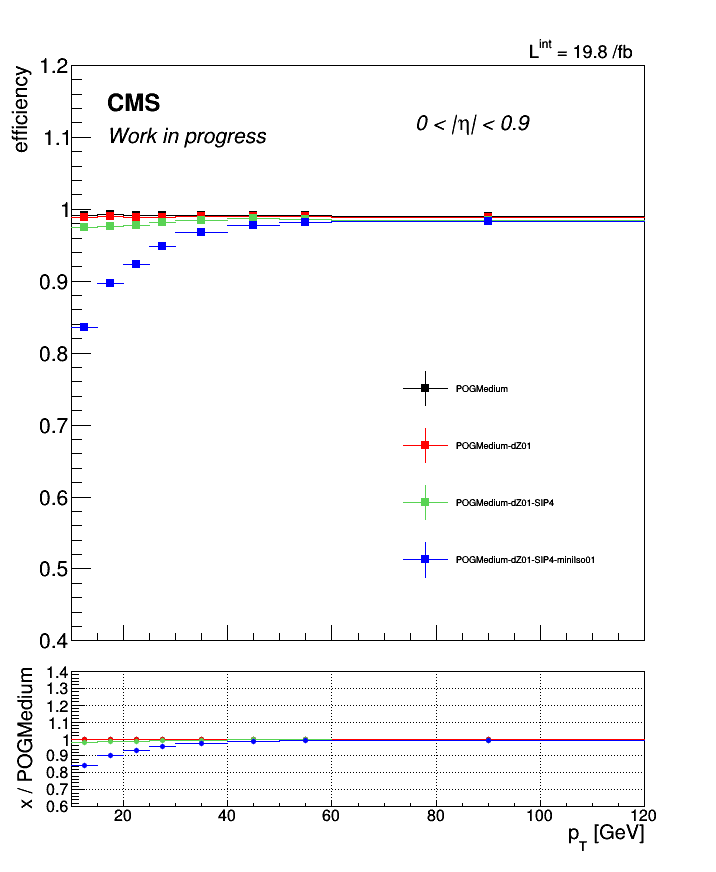

In [7]:
# 2016preVFP
from itertools import product
eras = ["2016preVFP", "2016postVFP", "2017", "2018"]
for era, isData in product(eras, [True, False]):
    hists = get_histo(era, isData)
    for iptbin in range(1, len(pt_bins)):
        configs = generate_configs(era=era, iptbin=iptbin, ietabin=0)
        if isData:
            figname = f"../www/HcToWA/UltraLegacy/MetaInfo/{era}/Muon/eff_change_data_pt_{int(pt_bins[iptbin-1])}to{int(pt_bins[iptbin])}.png"
        else:
            figname = f"../www/HcToWA/UltraLegacy/MetaInfo/{era}/Muon/eff_change_mc_pt_{int(pt_bins[iptbin-1])}to{int(pt_bins[iptbin])}.png" 
        cvs = Canvas(configs=configs)
        cvs.get_hists(hists)
        cvs.combine()
        cvs.savefig(figname)
    
    for ietabin in range(1, len(eta_bins)):
        configs = generate_configs(era=era, iptbin=0, ietabin=ietabin)
        if isData:
            figname = f"../www/HcToWA/UltraLegacy/MetaInfo/{era}/Muon/eff_change_data_pt_{eta_bins[ietabin-1]}to{eta_bins[ietabin]}.png"
        else:
            figname = f"../www/HcToWA/UltraLegacy/MetaInfo/{era}/Muon/eff_change_mc_pt_{eta_bins[ietabin-1]}to{eta_bins[ietabin]}.png" 
        cvs = Canvas(configs=configs)
        cvs.get_hists(hists)
        cvs.combine()
        cvs.savefig(figname)

hists = get_histo()
configs = generate_configs(era="2016preVFP", iptbin=0, ietabin=1)
cvs = Canvas(configs=configs)
cvs.get_hists(hists)
cvs.combine()
cvs.draw()